<a href="https://colab.research.google.com/github/pdragojevic/Predicting-NBA-Shots/blob/main/predicting_nba_shots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dense, Dropout
from keras.models import Sequential
import xgboost as xgb
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Učitavanje podataka

In [68]:
# load data
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/UZOP/project/shot_logs.csv")
# tranform data column names to lowercase
df.columns = df.columns.str.lower()

# Početni pregled podataka

In [69]:
df.head()

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [70]:
df.columns.values

array(['game_id', 'matchup', 'location', 'w', 'final_margin',
       'shot_number', 'period', 'game_clock', 'shot_clock', 'dribbles',
       'touch_time', 'shot_dist', 'pts_type', 'shot_result',
       'closest_defender', 'closest_defender_player_id', 'close_def_dist',
       'fgm', 'pts', 'player_name', 'player_id'], dtype=object)

Pojašnjenje značajki:

*   game_id - oznaka utakmice
*   matchup - ekipe koje su igrale susret
*   location - lokacija igranja (kod kuće ili u gostima)
*   w - pobjeda/ poraz
*   final_margin - konačna razlika u rezultatu
*   shot_number - broj pokušaja šuta
*   period - oznaka četvrtine (1.,2.,3. ili 4.)
*   game_clock - preostalo vrijeme u četvrtini 
*   shot_clock - preostalo vrijeme napada
*   dribbles - broj driblinga prije šuta
*   touch_time - vrijeme koje igrač drži loptu u rukama prije šuta
*   shot_dist - udaljenost od koša
*   pts_type - vrsta poena (2 ili 3)
*   shot_result - zabijen ili promašen šut (made ili missed)
*   closest_defender - najbliži obranmbeni igrač
*   closest_defender_player_id - id najbližeg obrambenog igrača
*   close_def_dist - udaljenost najbližeg obrambenog igrača
*   fgm - binarni zapisa postignutog koša
*   pts - vrijednost zabijenog koša (2 ili 3)
*   player_name - ime igrača
*   player_id - id igrača



In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   game_id                     128069 non-null  int64  
 1   matchup                     128069 non-null  object 
 2   location                    128069 non-null  object 
 3   w                           128069 non-null  object 
 4   final_margin                128069 non-null  int64  
 5   shot_number                 128069 non-null  int64  
 6   period                      128069 non-null  int64  
 7   game_clock                  128069 non-null  object 
 8   shot_clock                  122502 non-null  float64
 9   dribbles                    128069 non-null  int64  
 10  touch_time                  128069 non-null  float64
 11  shot_dist                   128069 non-null  float64
 12  pts_type                    128069 non-null  int64  
 13  shot_result   

# Pretprocesiranje podataka

Kreiranje kopije podataka nad kojom ćemo raditi pretprocesiranje.

In [72]:
new_df = df.copy()

Zamjena kategoričkih značajki sa vrijednostima 0 i 1, pretvorba game_clock u sekunde

In [73]:
# home/away game => 1/0
new_df.location = new_df.location.map({"H":1,"A":0})
# win/lose => 1/0
new_df.w = new_df.w.map({"W":1,"L":0})
# 2 pointer/ 3 pointer => 0/1
new_df.pts_type = new_df.pts_type.map({2:0,3:1})
new_df.shot_result = new_df.shot_result.map({"made":1,"missed":0})

new_df = new_df.rename(columns={"location":"home_away","pts_type":"3pts_shot"})

new_df.game_clock = new_df.game_clock.apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))

new_df['total_game_time'] = (new_df.period - 1) * 12 * 60 + new_df.game_clock

## Inženjerstvo značajki

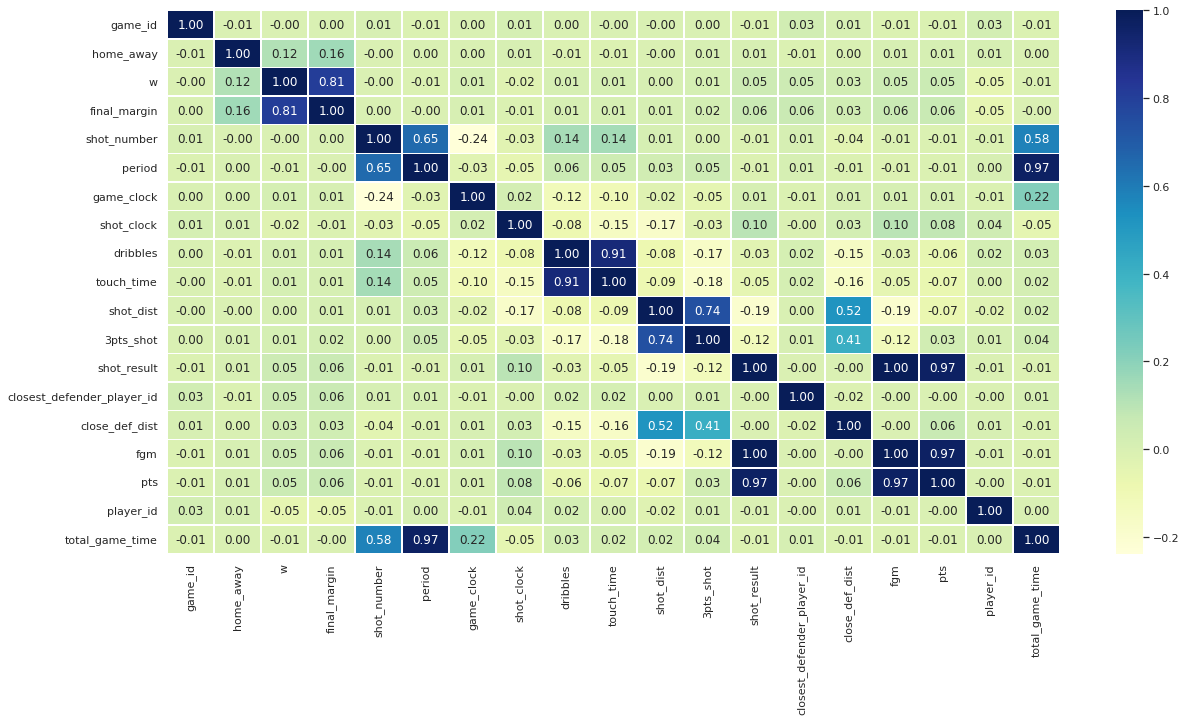

In [74]:
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(new_df.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.show()

Izbacujemo fgm i pts zato što savršeno ili skoro savršeno predviđaju da li je koš zabijen. Od ostalih značajki također izbacujemo game_id, matchup, closest_defender, closest_defender_player_id, player_name, player_id.

In [75]:
new_df = new_df.drop(columns =['game_id',
                               'matchup',
                               'closest_defender',
                               'closest_defender_player_id',
                               'player_name',
                               'player_id',
                               'fgm',
                               'pts'])

## Provjera nedostajućih vrijednosti.

In [76]:
new_df.isna().sum()

home_away             0
w                     0
final_margin          0
shot_number           0
period                0
game_clock            0
shot_clock         5567
dribbles              0
touch_time            0
shot_dist             0
3pts_shot             0
shot_result           0
close_def_dist        0
total_game_time       0
dtype: int64

In [77]:
new_df[new_df.shot_clock.isna()].head()

,home_away,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,touch_time,shot_dist,3pts_shot,shot_result,close_def_dist,total_game_time
2,0,1,24,3,1,0,NaN,3,2.7,10.1,0,0,0.9,0
24,0,1,12,6,2,4,NaN,0,0.7,25.2,1,0,3.6,724
54,1,0,-1,14,4,1,NaN,5,3.7,34.4,1,0,3.6,2161
76,1,1,7,10,3,1,NaN,2,3.6,13.1,0,1,2.5,1441
129,1,1,25,7,2,2,NaN,5,5.0,12.0,0,0,4.0,722


Zaključujem da se radi o završnim trenucima četvrtine, ostalo je manje od 24 sekunde, stoga u tim slučajevima shot_clock možemo zamijeniti s game_clock. Slučaj u kojem je game_clock veći od 24 možemo smatrati neisrpavnim unosom i staviti prosječno vrijeme za shot_clock.

In [78]:
print(len(new_df[(new_df.shot_clock.isna()) & (new_df.game_clock<24)]))
print(len(new_df[(new_df.shot_clock.isna()) & (new_df.game_clock>=24)]))

3550
2017


In [79]:
new_df.loc[(new_df.shot_clock.isna()) & (new_df.game_clock<24), 'shot_clock'] = new_df.loc[:,'game_clock']
new_df.loc[new_df.shot_clock.isna(), 'shot_clock'] = new_df.loc[:,'shot_clock'].mean()

## Provjera stršećih podataka

In [80]:
new_df.describe()

,home_away,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,touch_time,shot_dist,3pts_shot,shot_result,close_def_dist,total_game_time
count,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,0.499215,0.504377,0.208723,6.506899,2.469427,351.393811,12.221968,2.023355,2.765901,13.571504,0.264670,0.452139,4.123015,1409.380990
std,0.500001,0.499983,13.233267,4.713260,1.139919,207.590603,5.854232,3.477760,3.043682,8.888964,0.441159,0.497706,2.756446,841.127862
min,0.000000,0.000000,-53.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-163.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.000000,3.000000,1.000000,172.000000,8.000000,0.000000,0.900000,4.700000,0.000000,0.000000,2.300000,670.000000
50%,0.000000,1.000000,1.000000,5.000000,2.000000,352.000000,12.200000,1.000000,1.600000,13.700000,0.000000,0.000000,3.700000,1393.000000
75%,1.000000,1.000000,9.000000,9.000000,3.000000,531.000000,16.400000,2.000000,3.700000,22.500000,1.000000,1.000000,5.300000,2112.000000
max,1.000000,1.000000,53.000000,38.000000,7.000000,720.000000,24.000000,32.000000,24.900000,47.200000,1.000000,1.000000,53.200000,4610.000000


Text(0.5, 1.0, 'Box plot for close_def_dist')

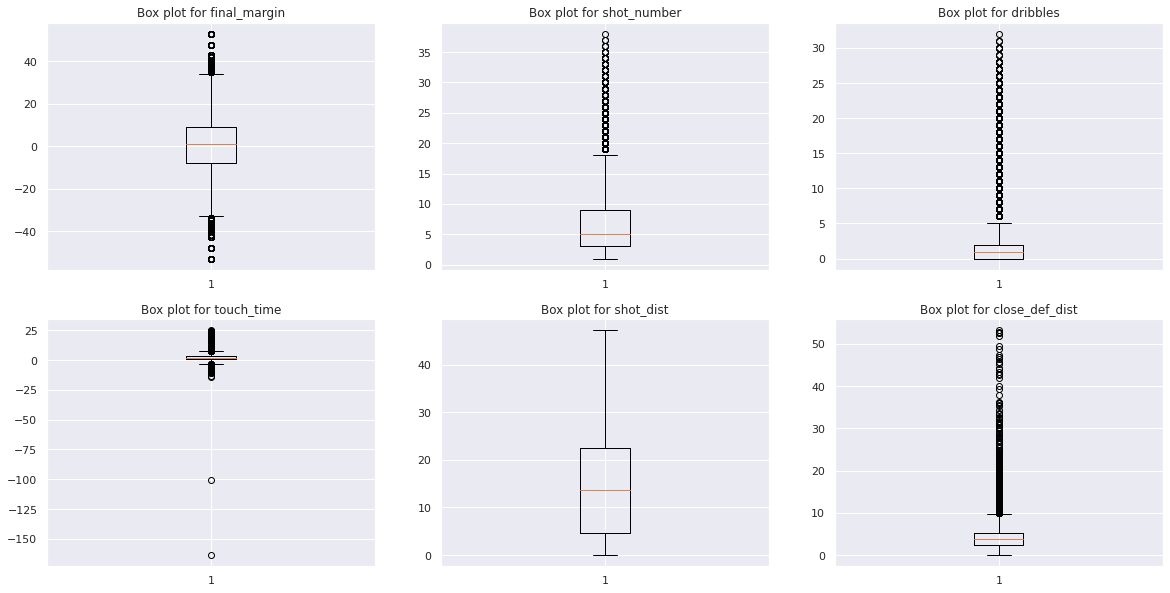

In [81]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax[0][0].boxplot(new_df.final_margin)
ax[0][0].set_title('Box plot for final_margin')

ax[0][1].boxplot(new_df.shot_number)
ax[0][1].set_title('Box plot for shot_number')

ax[0][2].boxplot(new_df.dribbles)
ax[0][2].set_title('Box plot for dribbles')

ax[1][0].boxplot(new_df.touch_time)
ax[1][0].set_title('Box plot for touch_time')

ax[1][1].boxplot(new_df.shot_dist)
ax[1][1].set_title('Box plot for shot_dist')

ax[1][2].boxplot(new_df.close_def_dist)
ax[1][2].set_title('Box plot for close_def_dist')

In [82]:
len(new_df[new_df.touch_time<0])

312

touch_time ne bi smio biti negativan, takvih zapisa je 312, pošto ih ima tako malo možemo ih izbaciti.

In [83]:
new_df = new_df[new_df['touch_time']>0]

In [84]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124711 entries, 0 to 128068
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   home_away        124711 non-null  int64  
 1   w                124711 non-null  int64  
 2   final_margin     124711 non-null  int64  
 3   shot_number      124711 non-null  int64  
 4   period           124711 non-null  int64  
 5   game_clock       124711 non-null  int64  
 6   shot_clock       124711 non-null  float64
 7   dribbles         124711 non-null  int64  
 8   touch_time       124711 non-null  float64
 9   shot_dist        124711 non-null  float64
 10  3pts_shot        124711 non-null  int64  
 11  shot_result      124711 non-null  int64  
 12  close_def_dist   124711 non-null  float64
 13  total_game_time  124711 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 14.3 MB


# Vizualizacija podataka

Prokazana je slika koja pokazuje zabijene odnosno promašene šuteve u odnosu na dvije značajke koje su u radu označene kao one koje najbolje pridonose predviđanju.

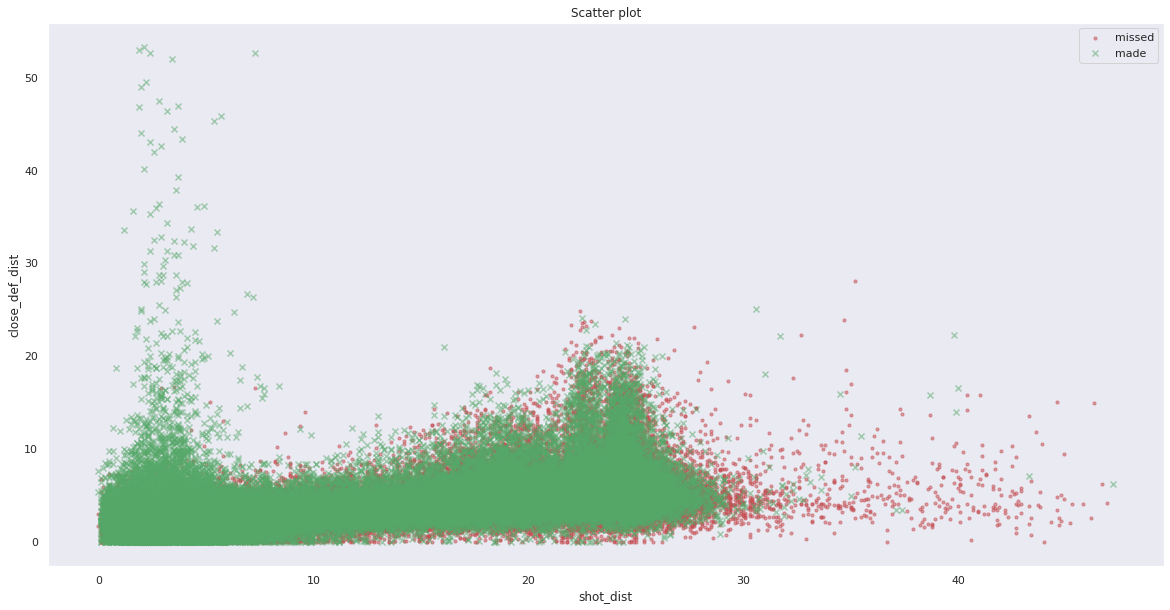

In [85]:
# mask
mask_made = new_df.shot_result == 1

# plot
plt.scatter(new_df.loc[~mask_made,'shot_dist'], new_df.loc[~mask_made,'close_def_dist'], s=10, alpha=0.5, c='r', label='missed')
plt.scatter(new_df.loc[mask_made,'shot_dist'], new_df.loc[mask_made,'close_def_dist'], alpha=0.5, marker='x', c='g', label='made')
plt.xlabel('shot_dist')
plt.ylabel('close_def_dist')
plt.title('Scatter plot')
plt.grid()
plt.legend(loc='best')
plt.show()

Prema slici vidimo da se uspješnost koša povećava što smo bliže košu i što je najbliži obrambeni igrač dalje.

Text(0.5, 1.0, 'Histogram for close_def_dist')

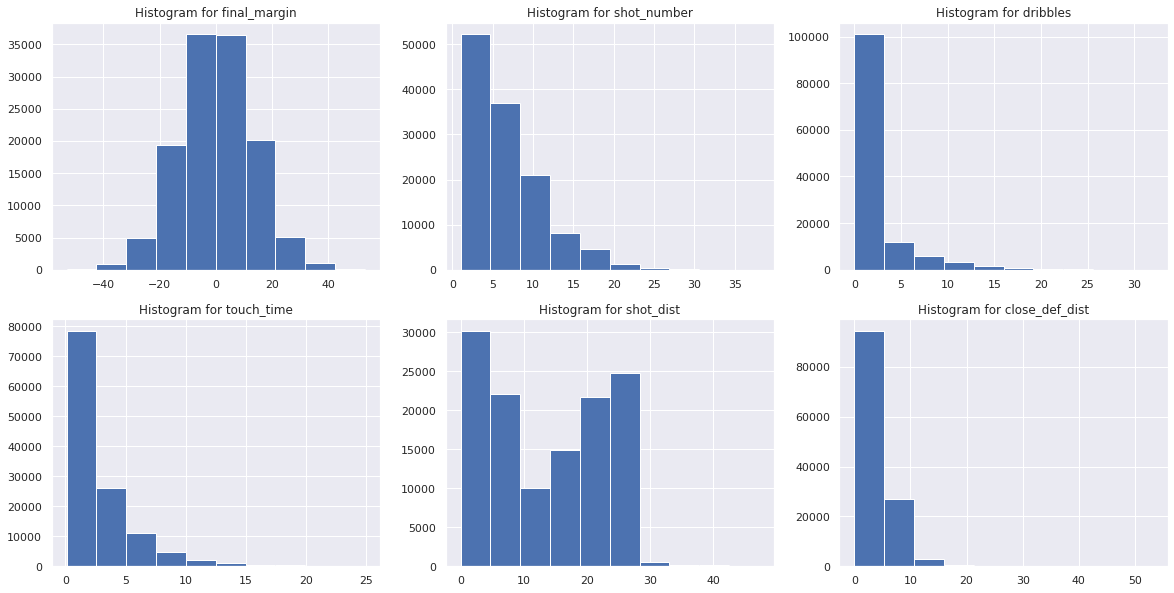

In [86]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
ax[0][0].hist(new_df.final_margin)
ax[0][0].set_title('Histogram for final_margin')

ax[0][1].hist(new_df.shot_number)
ax[0][1].set_title('Histogram for shot_number')

ax[0][2].hist(new_df.dribbles)
ax[0][2].set_title('Histogram for dribbles')

ax[1][0].hist(new_df.touch_time)
ax[1][0].set_title('Histogram for touch_time')

ax[1][1].hist(new_df.shot_dist)
ax[1][1].set_title('Histogram for shot_dist')

ax[1][2].hist(new_df.close_def_dist)
ax[1][2].set_title('Histogram for close_def_dist')

# Logistic Regression

Podjela podataka na ulaz i rezultat, te podjela na train i test podatke.

In [87]:
X  = new_df.drop('shot_result', axis=1)
y = new_df['shot_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [93]:
best_score = 0
for lr in [0.001, 0.00001, 0.000001]:
  logistic_regression_model = make_pipeline(StandardScaler(), SGDClassifier(loss='log', penalty="l2", eta0=lr))
  logistic_regression_model.fit(X_train, y_train)
  predict_results = logistic_regression_model.predict(X_test)
  score = logistic_regression_model.score(X_test, y_test)
  if score > best_score:
    best_lr = lr
    best_model = logistic_regression_model
    best_score = score
    best_predict_results = predict_results

print("Best learning rate:")
print(best_lr)
print('train accuracy:')
print(best_model.score(X_train, y_train))
print('test accuracy:')
print(best_model.score(X_test, y_test))

pd.crosstab(y_test, best_predict_results, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Best learning rate:
0.001
train accuracy:
0.6122135471618485
test accuracy:
0.6027902501603593


Predicted,0,1,All
Actual,,,
0,2628,826,3454
1,1651,1131,2782
All,4279,1957,6236


# SVM

In [ ]:
X  = new_df.drop('shot_result', axis=1)
y = new_df['shot_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=0.05, random_state=42)

In [ ]:
svm_model = svm.SVC()

svm_model.fit(X_train, y_train)

predict_results = svm_model.predict(X_test)

print('train accuracy:')
print(svm_model.score(X_train, y_train))
print('test accuracy:')
print(svm_model.score(X_test, y_test))

pd.crosstab(y_test, predict_results, rownames = ['Actual'], colnames =['Predicted'], margins = True)

train accuracy:
0.5973057493384653
test accuracy:
0.5984605516356639


Predicted,0,1,All
Actual,,,
0,2523,931,3454
1,1573,1209,2782
All,4096,2140,6236


#Neural Networks

In [ ]:
X  = new_df.drop('shot_result', axis=1)
y = new_df['shot_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
neural_network1_model = Sequential()
neural_network1_model.add(Dense(50, input_dim=13, activation="sigmoid"))
neural_network1_model.add(Dense(2, activation=" sigmoid"))
neural_network1_model.compile(loss='categorical_crossentropy')


neural_network2_model = Sequential()
neural_network2_model.add(Dense(50, input_dim=13, activation="relu"))
neural_network2_model.add(Dense(2, activation=" sigmoid"))

#Naive Bayes

In [ ]:
X  = new_df.drop('shot_result', axis=1)
y = new_df['shot_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(X_train, y_train)

predict_results = naive_bayes_model.predict(X_test)

print('train accuracy:')
print(naive_bayes_model.score(X_train, y_train))
print('test accuracy:')
print(naive_bayes_model.score(X_test, y_test))

pd.crosstab(y_test, predict_results, rownames = ['Actual'], colnames =['Predicted'], margins = True)

train accuracy:
0.5870521207005698
test accuracy:
0.577132777421424


Predicted,0,1,All
Actual,,,
0,2013,1441,3454
1,1196,1586,2782
All,3209,3027,6236


#Random Forest

In [ ]:
X  = new_df.drop('shot_result', axis=1)
y = new_df['shot_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
random_forest_model = RandomForestClassifier(min_samples_leaf=50)

random_forest_model.fit(X_train, y_train)

predict_results = random_forest_model.predict(X_test)

print('train accuracy:')
print(random_forest_model.score(X_train, y_train))
print('test accuracy:')
print(random_forest_model.score(X_test, y_test))

pd.crosstab(y_test, predict_results, rownames = ['Actual'], colnames =['Predicted'], margins = True)

train accuracy:
0.6506294603480074
test accuracy:
0.6116100064143681


Predicted,0,1,All
Actual,,,
0,2729,725,3454
1,1697,1085,2782
All,4426,1810,6236


#Boosting

In [ ]:
X  = new_df.drop('shot_result', axis=1)
y = new_df['shot_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
boost_model = xgb.XGBClassifier(max_depth=3, learning_rate =0.0001, n_estimators=1, min_child_weight=0.0001, objective="binary:logistic", random_state=42)

boost_model.fit(X_train, y_train)

predict_results = boost_model.predict(X_test)

print('train accuracy:')
print(boost_model.score(X_train, y_train))
print('test accuracy:')
print(boost_model.score(X_test, y_test))

pd.crosstab(y_test, predict_results, rownames = ['Actual'], colnames =['Predicted'], margins = True)

train accuracy:
0.6149483013293944
test accuracy:
0.6170622193713919


Predicted,0,1,All
Actual,,,
0,3121,333,3454
1,2055,727,2782
All,5176,1060,6236
